This kernel tremendously benefits from [Hieu Phungs work on Q-Learning](https://www.kaggle.com/phunghieu/connectx-with-q-learning) and [Keon Kims blog](https://keon.github.io/deep-q-learning/). The only thing I do is trying to understand the machinery behind Deep Q Learning with Keras and Gym. Comments are welcome.

## Initialization

In [1]:
import gym
import numpy as np
from math import exp, log
from random import choice, uniform, sample
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from kaggle_environments import evaluate, make

Using TensorFlow backend.


## Define Environment

The ConnectX environment below allows to play around with the setup in a clean gym style which makes it very easy to interact with current states. In order to train my agent properly, the `switch_side`and `switch_trainer` functions are called whenever we start a new game. Therefore, the agent (hopefully) learns to play on both sides of the board against *negamax* and the *random* opponent.

In [2]:
class ConnectX(gym.Env):
    
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(config.rows,config.columns,1), dtype=np.int)

    def switch_side(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)
    
    def switch_trainer(self):
        current_trainer_random = 'random' in self.pair 
        if current_trainer_random:
            self.pair = [None, 'negamax']
        else:
            self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
    
    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if uniform(0, 1) < self.switch_prob: # switch side
            self.switch_side()
        #if uniform(0, 1) < self.switch_prob: # switch trainer
        #    self.switch_trainer()        
        return self.trainer.reset()

## Deep Learning Agent

I am really not an expert in neural nets. Thus, all I do is playing around a bit. The magic in defining the agent as below is happening in the `replay` function: After gathering some experience, a neural network is trained to make sense of the `state`, `action` and `reward` relationship. The `target` is set such that the network aims at minimizing the loss between predicting the reward of the `next_state` and the realized reward.

In [16]:
# Deep Q-learning Agent
class DQNAgent:

    def __init__(self, state_size, action_size, episodes):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500)
        self.gamma = 0.9   # discount rate
        self.epsilon = 0.10  # initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = exp((log(self.epsilon_min) - log(self.epsilon))/(0.8*episodes)) # reaches epsilon_min after 80% of iterations
        self.model = self._build_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(20, input_dim=self.state_size, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr = 0.00001))
        return model
    
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon: # Exploration
            return choice([c for c in range(self.action_size) if state[:,c] == 0])
            #when exploring, I allow for "wrong" moves to give the agent a chance 
            #to experience the penalty of choosing full columns
            #return choice([c for c in range(self.action_size)])
        act_values = self.model.predict(state) # Exploitation
        action = np.argmax(act_values[0]) 
        return action
    
    def replay(self, batch_size):
        minibatch = sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

## Train the agent

Training is nothing as iteratively playing against the trainer, memorizing what happened and updating the neural net weights after each iteration. Notable thing here is that I let the agent also learn what a valid move is the hard way (a move is invalid if the agent chooses a column which is already full). After an invalid move the game is over (`done = True`) and I penalize invalid actions hard. 

In [17]:
# initialize gym environment and the agent
env = ConnectX(switch_prob = 0.5)
state_size = env.observation_space.shape[1]*env.observation_space.shape[0]
action_size = env.observation_space.shape[1]
episodes = 40000
agent = DQNAgent(state_size, action_size, episodes)
agent.load("./connectX-weights_deep.h5") # load prelearned weights
batch_size = 40 # Don't know if this number makes sense

# Monitoring devices
all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes)

# Iterate the game
for e in range(episodes):
    # reset state in the beginning of each game
    done = False
    state = env.reset()
    total_rewards = 0
    while not done:
        # Decide action
        action = int(agent.act(np.array([state.board])))
        next_state, reward, done, _ = env.step(action)
        if not done:
            reward = 0.0/42 # default: reward of 0.5 if not done/ 1 if win/ 0 if lost
        if done:
            if reward == 1: # Won
                reward = 1
            elif reward == 0: # Lost
                reward = -1
            else: # Draw
                reward = 0
        if state.board[action]!=0: # invalid move: hard penalization
            reward = -10
        agent.memorize(np.array([state.board]), action, reward, np.array([next_state.board]), done)
        # make next_state the new current state for the next frame.
        state = next_state
        total_rewards += reward
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
        all_total_rewards[e] = total_rewards
        avg_reward = all_total_rewards[max(0, e - 100):e].mean()
        all_avg_rewards[e] = avg_reward
        if e % 100 == 0 :
            agent.save("./connectX-weights_deep.h5")
            print("episode: {}/{}, epsilon: {:.2f}, average: {:.2f}".format(e, episodes, agent.epsilon, avg_reward))

Invalid Action: Invalid column: 2
episode: 100/40000, epsilon: 0.10, average: 0.58
episode: 200/40000, epsilon: 0.10, average: 0.43
episode: 300/40000, epsilon: 0.10, average: 0.64
episode: 400/40000, epsilon: 0.10, average: 0.72
Invalid Action: Invalid column: 1
episode: 500/40000, epsilon: 0.10, average: 0.61
Invalid Action: Invalid column: 1
Invalid Action: Invalid column: 1
episode: 600/40000, epsilon: 0.10, average: 0.44
episode: 700/40000, epsilon: 0.10, average: 0.72
episode: 800/40000, epsilon: 0.09, average: 0.60
episode: 900/40000, epsilon: 0.09, average: 0.72
episode: 1000/40000, epsilon: 0.09, average: 0.50
Invalid Action: Invalid column: 1
episode: 1100/40000, epsilon: 0.09, average: 0.55
episode: 1200/40000, epsilon: 0.09, average: 0.54
episode: 1300/40000, epsilon: 0.09, average: 0.78
Invalid Action: Invalid column: 1
episode: 1400/40000, epsilon: 0.09, average: 0.59
episode: 1500/40000, epsilon: 0.09, average: 0.52
Invalid Action: Invalid column: 1
episode: 1600/40000, 

Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 2
episode: 11600/40000, epsilon: 0.04, average: 0.31
Invalid Action: Invalid column: 0
episode: 11700/40000, epsilon: 0.04, average: 0.49
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 2
episode: 11800/40000, epsilon: 0.04, average: 0.26
episode: 11900/40000, epsilon: 0.04, average: 0.62
episode: 12000/40000, epsilon: 0.04, average: 0.68
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 0
episode: 12100/40000, epsilon: 0.04, average: 0.28
Invalid Action: Invalid column: 2
episode: 12200/40000, epsilon: 0.04, average: 0.37
episode: 12300/40000, epsilon: 0.04, average: 0.46
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 6
Invalid Action: Invalid column: 2
episode: 12400/40000, epsilon: 0.04, average: 0.15
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 6
episode: 12500/40000, epsilon: 0.04, average: 0.48
Invalid Action: Invalid column: 6
Invalid Action

episode: 22300/40000, epsilon: 0.02, average: 0.62
episode: 22400/40000, epsilon: 0.02, average: 0.72
episode: 22500/40000, epsilon: 0.02, average: 0.52
episode: 22600/40000, epsilon: 0.02, average: 0.80
Invalid Action: Invalid column: 3
episode: 22700/40000, epsilon: 0.02, average: 0.57
Invalid Action: Invalid column: 6
episode: 22800/40000, epsilon: 0.02, average: 0.49
episode: 22900/40000, epsilon: 0.02, average: 0.66
episode: 23000/40000, epsilon: 0.02, average: 0.74
episode: 23100/40000, epsilon: 0.02, average: 0.68
Invalid Action: Invalid column: 1
episode: 23200/40000, epsilon: 0.02, average: 0.59
episode: 23300/40000, epsilon: 0.02, average: 0.58
Invalid Action: Invalid column: 2
Invalid Action: Invalid column: 6
episode: 23400/40000, epsilon: 0.02, average: 0.54
episode: 23500/40000, epsilon: 0.02, average: 0.68
episode: 23600/40000, epsilon: 0.02, average: 0.58
episode: 23700/40000, epsilon: 0.02, average: 0.70
episode: 23800/40000, epsilon: 0.02, average: 0.72
Invalid Action

episode: 36000/40000, epsilon: 0.01, average: 0.60
episode: 36100/40000, epsilon: 0.01, average: 0.62
Invalid Action: Invalid column: 1
episode: 36200/40000, epsilon: 0.01, average: 0.59
episode: 36300/40000, epsilon: 0.01, average: 0.70
Invalid Action: Invalid column: 2
episode: 36400/40000, epsilon: 0.01, average: 0.61
Invalid Action: Invalid column: 0
Invalid Action: Invalid column: 6
episode: 36500/40000, epsilon: 0.01, average: 0.42
episode: 36600/40000, epsilon: 0.01, average: 0.72
episode: 36700/40000, epsilon: 0.01, average: 0.58
episode: 36800/40000, epsilon: 0.01, average: 0.80
episode: 36900/40000, epsilon: 0.01, average: 0.64
Invalid Action: Invalid column: 0
episode: 37000/40000, epsilon: 0.01, average: 0.43
episode: 37100/40000, epsilon: 0.01, average: 0.64
episode: 37200/40000, epsilon: 0.01, average: 0.64
episode: 37300/40000, epsilon: 0.01, average: 0.66
episode: 37400/40000, epsilon: 0.01, average: 0.70
episode: 37500/40000, epsilon: 0.01, average: 0.62
episode: 37600

## Did the agent learn anything?

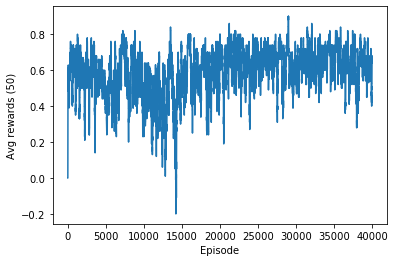

In [18]:
import matplotlib.pyplot as plt
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (50)')
plt.show()

## Create the agent

Only relevant for submission. Somewhat cumbersome procedure because Kaggle does not allow `keras`modules for submission but the below procedure seems to work

In [19]:
model = Sequential()
model = Sequential()
model.add(Dense(20, input_dim=state_size, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.load_weights('connectX-weights_deep.h5')

layers = []

# Get all layers' weights
for i in range(3):
    weights, biases = model.layers[i].get_weights()
    layers.extend([weights, biases])

fc_layers = list(map(
    lambda x: str(list(np.round(x, 8))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', '') \
        .replace(',dtype=float32',''),
    layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''
# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)

my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])
my_agent += '''
    state = observation.board[:]
#    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)
'''

for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n' # Sigmoid function

my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'
my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

with open('submission.py', 'w') as f:
    f.write(my_agent)

## Verify and Evaluate the agent

In [21]:
from submission import my_agent

env = make("connectx", debug=True)
env.run([my_agent, my_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=50)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=50)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

Success!
My Agent vs. Random Agent: 0.78
Random Agent vs. My Agent: 0.16
My Agent vs. Negamax Agent: 0.0
Negamax Agent vs. My Agent: 1.0
